In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [3]:
air_df= pd.read_excel("Air_qual_data.xlsm")

In [4]:
air_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 435742 entries, 0 to 435741
Data columns (total 13 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   stn_code                     291665 non-null  object        
 1   sampling_date                435739 non-null  object        
 2   state                        435742 non-null  object        
 3   location                     435739 non-null  object        
 4   agency                       286261 non-null  object        
 5   type                         430349 non-null  object        
 6   so2                          401096 non-null  float64       
 7   no2                          419509 non-null  float64       
 8   rspm                         395520 non-null  float64       
 9   spm                          198355 non-null  float64       
 10  location_monitoring_station  408251 non-null  object        
 11  pm2_5                     

In [5]:
air_df.isnull().sum()/air_df.shape[0]*100

stn_code                       33.064749
sampling_date                   0.000688
state                           0.000000
location                        0.000688
agency                         34.304933
type                            1.237659
so2                             7.951035
no2                             3.725370
rspm                            9.230692
spm                            54.478797
location_monitoring_station     6.309009
pm2_5                          97.862497
date                            0.001606
dtype: float64

# EDA

<AxesSubplot:>

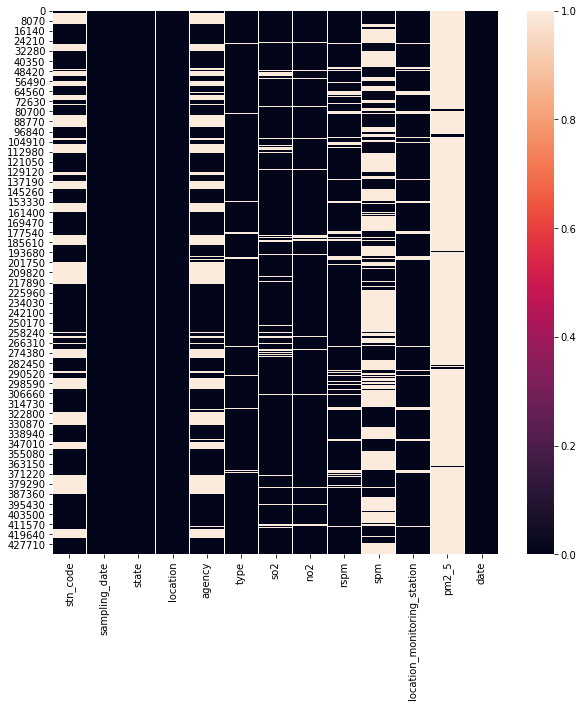

In [6]:
## plotting heatmap of null values
plt.figure(figsize=(10,10))
sns.heatmap(air_df.isnull())

In [7]:
air_df.drop_duplicates(inplace=True)

In [8]:
air_df.shape

(435068, 13)

In [9]:
air_df.dropna(thresh=3, inplace= True)
air_df.shape

(435065, 13)

In [10]:
air_df.isnull().sum()/air_df.shape[0]*100

stn_code                       33.115511
sampling_date                   0.000000
state                           0.000000
location                        0.000000
agency                         34.354177
type                            1.230621
so2                             7.959500
no2                             3.727949
rspm                            9.201384
spm                            54.452783
location_monitoring_station     6.274924
pm2_5                          97.859170
date                            0.000919
dtype: float64

In [11]:
## imputing type
air_df.type.value_counts()

Residential, Rural and other Areas    178608
Industrial Area                        95988
Residential and others                 86791
Industrial Areas                       51747
Sensitive Area                          8856
Sensitive Areas                         5536
RIRUO                                   1304
Sensitive                                490
Industrial                               233
Residential                              158
Name: type, dtype: int64

In [12]:
air_df["type"]=["Industrial Area" if x in ("Industrial Area","Industrial Areas", "Industrial") else x for x in air_df["type"]]
air_df["type"]=["Sensitive Area" if x in ("Sensitive Area","Sensitive Areas", "Sensitive") else x for x in air_df["type"]]
air_df["type"]=["Residential, Rural and other Areas" if x in ("Residential, Rural and other Areas","Residential and others", "Residential") else x for x in air_df["type"]]
air_df["type"].fillna("RIRUO", inplace=True)
air_df["type"].isnull().sum()



0

In [13]:
air_df.type.value_counts()

Residential, Rural and other Areas    265557
Industrial Area                       147968
Sensitive Area                         14882
RIRUO                                   6658
Name: type, dtype: int64

In [18]:
air_df[["so2", "no2", "rspm", "spm", "pm2_5"]].isnull().sum()

so2       34629
no2       16219
rspm      40032
spm      236905
pm2_5    425751
dtype: int64

In [19]:
## imputing so2 with mean and other vars with median:
## imputing on the basis of location and type
## imputing so2, no2, rspm, spm, pm2_5
# plotting distplot to see the trend

df2=air_df.copy()
type_lst=air_df.type.value_counts().keys()
for var in type_lst:
    val =df2[df2.loc[:,"type"]==var]["so2"].mean()
    df2.update(df2[df2.loc[:,"type"]==var]["so2"].replace(np.nan,val))
    
   
    
df2["so2"].isnull().sum()
df2["pm2_5"].isnull().sum()


425751

In [20]:
## imputing no2,rspm,spm,pm2_5 with median
type_lst=air_df.type.value_counts().keys()
var_to_imp=["no2","rspm","spm", "pm2_5"]
for value in var_to_imp:
    for var in type_lst:
      val =df2[df2.loc[:,"type"]==var][value].median()
      df2.update(df2[df2.loc[:,"type"]==var][value].replace(np.nan,val))
df2["pm2_5"].fillna(31,inplace=True)    
df2[var_to_imp].isnull().sum()
df2["pm2_5"].fillna(31,inplace=True)


In [21]:
air_df.update(df2)
air_df[var_to_imp].isnull().sum()

no2      0
rspm     0
spm      0
pm2_5    0
dtype: int64

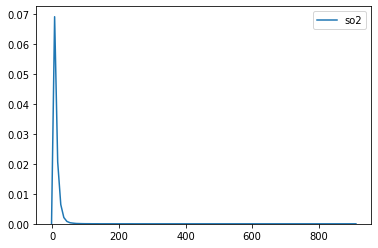

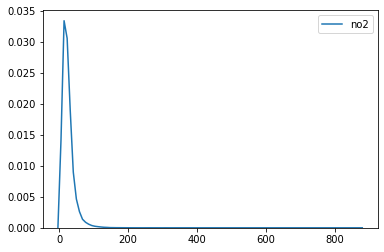

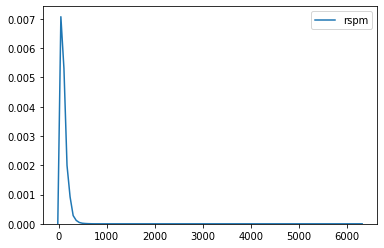

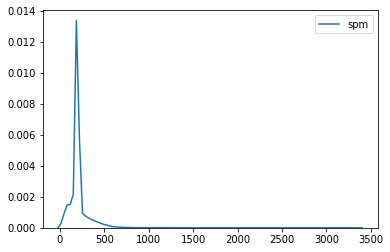

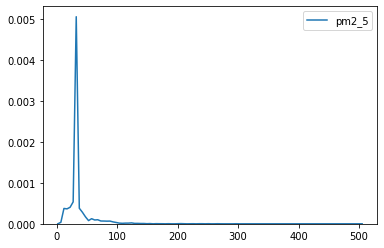

In [22]:
## imputing so2, no2, rspm, spm, pm2_5
# plotting distplot to see the trend
var_in_int=["so2", "no2", "rspm", "spm", "pm2_5"]
df2=air_df.copy()

for var in var_in_int:
    
    sns.distplot(air_df[[var]], hist=False ,label=var)
    plt.show()


# Model building

In [23]:
## calculating air quality index for so2, no2, pm2_5

In [24]:
# Pm2.5 to AQI
def pm25_to_aqi(x):
    
        if (x>=0 and x < 12.1):
            aqih = 50.0
            aqil = 0.0
            bphi = 12.0
            bplo = 0.0
            cp = x
            aqi = ((aqih-aqil)/(bphi-bplo)*(cp-bplo))+aqih
            return aqi
        elif (x>=12.1 and x<=35.4):
            aqih = 100
            aqil = 51
            bphi = 35.4
            bplo = 12.1
            cp = x
            aqi = ((aqih-aqil)/(bphi-bplo)*(cp-bplo))+aqih
            return aqi
        elif (x>=35.5 and x<=55.4):
            aqih = 150
            aqil = 101
            bphi = 55.4
            bplo = 35.5
            cp = x
            aqi = ((aqih-aqil)/(bphi-bplo)*(cp-bplo))+aqih
            return aqi
        elif (x>=55.5 and x<=150.4):
            aqih = 200
            aqil = 151
            bphi = 150.4
            bplo = 55.5
            cp = x
            aqi = ((aqih-aqil)/(bphi-bplo)*(cp-bplo))+aqih
            return aqi
        elif (x>=150.5 and x<=250.4):
            aqih = 300
            aqil = 201
            bphi = 250.4
            bplo = 150.5
            cp = x
            aqi = ((aqih-aqil)/(bphi-bplo)*(cp-bplo))+aqih
            return aqi
        elif (x>=250.5 and x <=350.4):
            aqih = 400
            aqil = 301
            bphi = 350.4
            bplo = 250.5
            cp = x
            aqi = ((aqih-aqil)/(bphi-bplo)*(cp-bplo))+aqih
            return aqi
        elif (x>=350.5 and x<=500.4):
            aqih = 500
            aqil = 401
            bphi = 550.4
            bplo = 350.5
            cp = x
            aqi = ((aqih-aqil)/(bphi-bplo)*(cp-bplo))+aqih
            return aqi
        else:
            #print('Highly polluted space')
            aqi = 580
            return aqi


In [25]:
def so2_to_aqi(x):
   
        if (x>=0 and  x<= 35):
            aqih = 50
            aqil = 0
            bphi = 35
            bplo = 0
            cp = x
            aqi = ((aqih-aqil)/(bphi-bplo)*(cp-bplo))+aqih
            return aqi
        elif (x>=36 and x<=75):
            aqih = 100
            aqil = 51
            bphi = 75
            bplo = 36
            cp = x
            aqi = ((aqih-aqil)/(bphi-bplo)*(cp-bplo))+aqih
            return aqi
        elif (x>=76 and x<=185):
            aqih = 150
            aqil = 101
            bphi = 185
            bplo = 76
            cp = x
            aqi = ((aqih-aqil)/(bphi-bplo)*(cp-bplo))+aqih
            return aqi
        elif (x>=186 and x<=304):
            aqih = 200
            aqil = 151
            bphi = 304
            bplo = 186
            cp = x
            aqi = ((aqih-aqil)/(bphi-bplo)*(cp-bplo))+aqih
            return aqi
        elif (x>=305 and x<=604):
            aqih = 300
            aqil = 201
            bphi = 604
            bplo = 305
            cp = x
            aqi = ((aqih-aqil)/(bphi-bplo)*(cp-bplo))+aqih
            return aqi
        elif (x>=605 and x<=804):
            aqih = 400
            aqil = 301
            bphi = 605
            bplo = 804
            cp = x
            aqi = ((aqih-aqil)/(bphi-bplo)*(cp-bplo))+aqih
            return aqi
        elif (x>=805 and x<=1004):
            aqih = 500
            aqil = 401
            bphi = 550.4
            bplo = 350.5
            cp = x
            aqi = ((aqih-aqil)/(bphi-bplo)*(cp-bplo))+aqih
            return aqi
        else:
            #print('Highly polluted space')
            aqi = 830
            return aqi

In [26]:

def no2_to_aqi(x):
    
        if (x>=0 and x <= 53):
            aqih = 50
            aqil = 0
            bphi = 53
            bplo = 0
            cp = x
            aqi = ((aqih-aqil)/(bphi-bplo)*(cp-bplo))+aqih
            return aqi
        elif (x>=54 and x<=100):
            aqih = 100
            aqil = 51
            bphi = 100
            bplo = 54
            cp = x
            aqi = ((aqih-aqil)/(bphi-bplo)*(cp-bplo))+aqih
            return aqi
        elif (x>=101 and x<=360):
            aqih = 150
            aqil = 101
            bphi = 360
            bplo = 101
            cp = x
            aqi = ((aqih-aqil)/(bphi-bplo)*(cp-bplo))+aqih
            return aqi
        elif (x>=361 and x<=649):
            aqih = 200
            aqil = 151
            bphi = 649
            bplo = 361
            cp = x
            aqi = ((aqih-aqil)/(bphi-bplo)*(cp-bplo))+aqih
            return aqi
        elif (x>=650 and x<=1249):
            aqih = 300
            aqil = 201
            bphi = 1249
            bplo = 650
            cp = x
            aqi = ((aqih-aqil)/(bphi-bplo)*(cp-bplo))+aqih
            return aqi
        elif (x>=1250 and x<=1649):
            aqih = 400
            aqil = 301
            bphi = 1649
            bplo = 1250
            cp = x
            aqi = ((aqih-aqil)/(bphi-bplo)*(cp-bplo))+aqih
            return aqi
        elif (x>=1650 and x<=2049):
            aqih = 500
            aqil = 401
            bphi = 2049
            bplo = 1650
            cp = x
            aqi = ((aqih-aqil)/(bphi-bplo)*(cp-bplo))+aqih
            return aqi
        else:
            #print('Highly polluted space')
            aqi = 600
            return aqi

In [27]:
def classify_aqi(x):
        if x<=50:
            return 'Good'
        elif x>=51 and x<=100:
            return 'Moderate'
        elif x>=101 and x<=150:
            return 'Unhealthy for Sensitive Groups'
        elif x>=151 and x<=200:
            return 'Unhealthy'
        elif x>=201 and x<=300:
            return 'Very unhealthy'
        elif x>=301 and x<=400:
            return 'Hazardous'
        elif x>=401 and x<=500:
            return 'Hazardous'
        else:
            return "Extremely Hazardous"

In [28]:
df2["so2_AQI"]= df2["so2"].apply(lambda x: so2_to_aqi(x))
df2["no2_AQI"]= df2["no2"].apply(lambda x: no2_to_aqi(x))
df2["pm2_5_AQI"]=df2["pm2_5"].apply(lambda x:pm25_to_aqi(x))


df2["max_aqi"]=df2[["so2","no2","pm2_5"]].max(axis=1)
df2["aqi_cat"]=df2["max_aqi"].apply(lambda x:classify_aqi(x) )


## updating air_df

air_df["max_aqi"]=df2["max_aqi"]
air_df["aqi_cat"]=df2["aqi_cat"]


<AxesSubplot:>

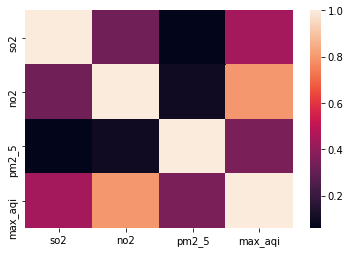

In [29]:
## relation bet so2, no2, pm2_5 and aqi

sns.heatmap(air_df[["so2","no2","pm2_5","max_aqi"]].corr())





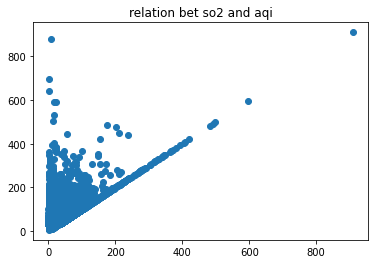

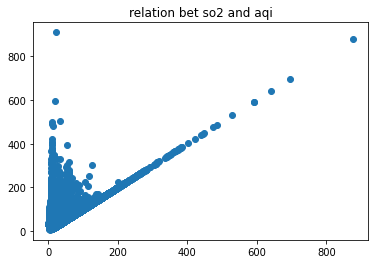

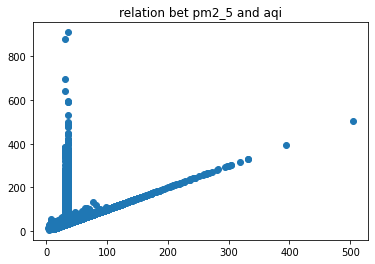

In [30]:
plt.scatter(air_df["so2"], air_df["max_aqi"])
plt.title("relation bet so2 and aqi")
plt.show()

plt.scatter(air_df["no2"], air_df["max_aqi"])
plt.title("relation bet so2 and aqi")
plt.show()

plt.scatter(air_df["pm2_5"], air_df["max_aqi"])
plt.title("relation bet pm2_5 and aqi")
plt.show()

In [31]:
pred_df=air_df[["so2","no2","pm2_5","rspm","spm", "type"]]
target_col=air_df["max_aqi"]

In [32]:
pred_df=pd.get_dummies(data=pred_df, columns=["type"])
pred_df.columns

Index(['so2', 'no2', 'pm2_5', 'rspm', 'spm', 'type_Industrial Area',
       'type_RIRUO', 'type_Residential, Rural and other Areas',
       'type_Sensitive Area'],
      dtype='object')

In [33]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(pred_df, target_col, test_size=0.4, random_state=1)

In [34]:
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()
sc.fit(x_train[["so2","no2","rspm","spm"]])
x_train[["so2","no2","rspm","spm"]]=sc.transform(x_train[["so2","no2","rspm","spm"]])
x_test[["so2","no2","rspm","spm"]]=sc.transform(x_test[["so2","no2","rspm","spm"]])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\suhasini.gupta\AppData\Roaming\Python\Python36\site-packages\pandas\core\indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

In [35]:
x_train.head()

,so2,no2,pm2_5,rspm,spm,type_Industrial Area,type_RIRUO,"type_Residential, Rural and other Areas",type_Sensitive Area
352428,-0.826421,-1.030052,35.0,-1.068640,-1.275109,1,0,0,0
407689,-0.077681,-0.421126,35.0,0.493691,0.073252,1,0,0,0
110160,0.240844,-0.650155,35.0,3.294793,3.648645,1,0,0,0
81391,0.175018,-0.819200,31.0,-0.310586,-0.108872,0,0,1,0
317997,-0.358458,-0.530188,31.0,-0.352186,-0.239874,0,0,1,0


In [36]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge
modelA=LinearRegression()
modelA.fit(x_train,y_train)
a=modelA.score(x_test,y_test)
a

0.7507829122594856

In [37]:
modelB=Lasso(alpha=3)
modelB.fit(x_train,y_train)
b=modelB.score(x_test,y_test)
b

0.6786289118604041

In [38]:
modelC=Ridge(alpha=5)
modelC.fit(x_train,y_train)
c=modelC.score(x_test,y_test)
c

0.7507835696301636

In [39]:
from sklearn.tree import DecisionTreeRegressor
modelD=DecisionTreeRegressor(random_state=1,max_depth=4)
modelD.fit(x_train,y_train)
modelD.score(x_test,y_test)

0.8976682991514966

In [40]:
from sklearn.ensemble import RandomForestRegressor

modelE=RandomForestRegressor(n_estimators=100)
modelE.fit(x_train,y_train)
modelE.score(x_test,y_test)

0.9979756337082911

In [41]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
map_val={'Good':6,'Moderate':5,'Unhealthy for Sensitive Groups':4,
         'Unhealthy':3,'Very unhealthy':2,'Hazardous':1,'Extremely Hazardous':0}
pred_df=air_df[["so2","no2","pm2_5","rspm","spm", "type"]]
tar_df2=air_df["aqi_cat"].map(map_val)
pred_df=pd.get_dummies(data=pred_df, columns=["type"])

x_1, x_2, y_1, y_2= train_test_split(pred_df, tar_df2, test_size=0.4, random_state=1)
sc2=StandardScaler()
sc2.fit(x_train[["so2","no2","rspm","spm"]])
x_1[["so2","no2","rspm","spm"]]=sc2.transform(x_1[["so2","no2","rspm","spm"]])
x_2[["so2","no2","rspm","spm"]]=sc2.transform(x_2[["so2","no2","rspm","spm"]])


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
C:\Users\suhasini.gupta\AppData\Roaming\Python\Python36\site-packages\pandas\core\indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

In [42]:
from sklearn.tree import DecisionTreeClassifier
model2=DecisionTreeClassifier()
model2.fit(x_1,y_1)
model2.score(x_2,y_2)

0.9999310447864113